In [1]:
import pandas as pd  #იმპორტები
import numpy as np
import torch
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
!pip install evaluate
!pip install -q transformers datasets evaluate gradio accelerate scikit-learn matplotlib
import evaluate
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.8 MB/s eta 0:00:00


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = load_dataset("Arseniy-Sandalov/Georgian-Sentiment-Analysis")
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Dataset.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/4219 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'sentiment', 'perturbation'],
        num_rows: 4219
    })
})


In [4]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # ვწმენდ დატას და ვშლი ლინკებს
    text = re.sub(r'\s+', ' ', text).strip() # ზედმეტი სფეისების წაშლა
    return text

dataset = dataset.map(lambda x: {"text": clean_text(x["text"])})

Map:   0%|          | 0/4219 [00:00<?, ? examples/s]

In [5]:
dataset['train'][0] #შევამოწმე მუშაობა

{'text': 'ამჟამად, სამაშველო და სტიქიის შედეგების სალიკვიდაციო სამუშაოები მიმდინარეობს, რომელშიც მერიის სამსახურებთან და შსს-ის დანაყოფებთან ერთად ასევე ჩართულია თავდაცვის სამინისტროს პირადი შემადგენლობა',
 'sentiment': 'Positive',
 'perturbation': None}

In [6]:
dataset = dataset.filter(lambda x: x["sentiment"] in ["Negative", "Neutral", "Positive"])

Filter:   0%|          | 0/4219 [00:00<?, ? examples/s]

In [7]:
dataset_no_mixed = dataset.filter(   ## ამოვშალე mixed ტექსტი
    lambda x: x["sentiment"] in ["Negative", "Neutral", "Positive"]
)

Filter:   0%|          | 0/3913 [00:00<?, ? examples/s]

In [8]:
from collections import Counter  #შევამოწმე

labels = [ex["sentiment"] for ex in dataset_no_mixed['train']]
Counter(labels)

Counter({'Positive': 765, 'Negative': 1417, 'Neutral': 1731})

In [9]:
def filter_labels(example): # მივანიჭე Labels
    return example['sentiment'] in ["Negative", "Neutral", "Positive"]

dataset['train'] = dataset['train'].filter(filter_labels)

Filter:   0%|          | 0/3913 [00:00<?, ? examples/s]

In [10]:
label_mapping = {"Negative":0, "Neutral":1, "Positive":2}
def encode_labels(example):
    example["label"] = label_mapping[example["sentiment"]]
    return example

In [11]:
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [12]:
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [13]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3130 [00:00<?, ? examples/s]

Map:   0%|          | 0/783 [00:00<?, ? examples/s]

In [14]:
split_data = dataset["train"].train_test_split(test_size=0.2, seed=42)

train_dataset = split_data["train"]
test_dataset = split_data["test"]

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Train size: 2504, Test size: 626


Map:   0%|          | 0/2504 [00:00<?, ? examples/s]

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

In [18]:
from datasets import load_dataset

dataset = load_dataset("Arseniy-Sandalov/Georgian-Sentiment-Analysis")

print(dataset['train'].column_names)

['text', 'sentiment', 'perturbation']


In [20]:
from datasets import load_dataset
import pandas as pd

raw_dataset = load_dataset("Arseniy-Sandalov/Georgian-Sentiment-Analysis")

df = pd.DataFrame(raw_dataset['train'])

df = df.rename(columns={'sentiment': 'label'})
df = df[['text', 'label']]

from datasets import Dataset
full_dataset = Dataset.from_pandas(df)

dataset_split = full_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_split["train"]
test_dataset = dataset_split["test"]

print("დატასეტი მზადაა", train_dataset.column_names)

დატასეტი მზადაა ['text', 'label']


In [25]:
label_map = {"negative": 0, "neutral": 1, "positive": 2}

def map_labels(example):
    if isinstance(example["label"], str):
        return {"label": label_map.get(example["label"].lower(), 1)}
    return {"label": int(example["label"])}

train_dataset = train_dataset.map(map_labels)
test_dataset = test_dataset.map(map_labels)

print("ლეიბლები გადაკონვერტირდა ციფრებში")

Map:   0%|          | 0/3375 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

ლეიბლები გადაკონვერტირდა ციფრებში


In [27]:
def encode_labels(example):
    val = example["label"]

    if isinstance(val, int):
        return {"label": val}

    mapping = {"negative": 0, "neutral": 1, "positive": 2}

    if str(val).isdigit():
        return {"label": int(val)}

    return {"label": mapping.get(str(val).lower(), 1)}

train_dataset = train_dataset.map(encode_labels)
test_dataset = test_dataset.map(encode_labels)

print(type(train_dataset[0]['label']))

Map:   0%|          | 0/3375 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

<class 'int'>


In [29]:
from transformers import AutoTokenizer

model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3375 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

In [30]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

labels = train_dataset["label"]

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")

print("weights_tensor შეიქმნა")
print("წონებია:", weights_tensor)

weights_tensor შეიქმნა
წონებია: tensor([0.9894, 0.6940, 1.8233], device='cuda:0')


In [34]:
from sklearn.utils.class_weight import compute_class_weight

# ვითვლით წონებს
labels = train_dataset["label"]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.664726
2,No log,0.614986
3,0.525200,0.658962


TrainOutput(global_step=633, training_loss=0.4850419332254178, metrics={'train_runtime': 406.8962, 'train_samples_per_second': 24.883, 'train_steps_per_second': 1.556, 'total_flos': 666005838624000.0, 'train_loss': 0.4850419332254178, 'epoch': 3.0})

In [37]:

from collections import Counter
print("არსებული ლეიბლები:", Counter(dataset_split['train']['label']))

label_map = {"negative": 0, "neutral": 1, "positive": 2}

def map_labels(example):
    val = str(example["label"]).lower()
    return {"label": label_map.get(val, 1)}

train_ds = dataset_split['train'].map(map_labels)

negatives = train_ds.filter(lambda x: x['label'] == 0)
neutrals  = train_ds.filter(lambda x: x['label'] == 1)
positives = train_ds.filter(lambda x: x['label'] == 2)

print(f"ნეგატიური: {len(negatives)}, ნეიტრალური: {len(neutrals)}, პოზიტიური: {len(positives)}")

არსებული ლეიბლები: Counter({'Neutral': 1374, 'Negative': 1137, 'Positive': 617, 'Mixed': 247})


Map:   0%|          | 0/3375 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3375 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3375 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3375 [00:00<?, ? examples/s]

ნეგატიური: 1137, ნეიტრალური: 1621, პოზიტიური: 617


In [38]:
import gc
from accelerate import Accelerator

gc.collect()
torch.cuda.empty_cache()
Accelerator().free_memory()

model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=3)
model.to("cuda" if torch.cuda.is_available() else "cpu")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [40]:
import numpy as np
import evaluate

# ჩავტვირთე accuracy-ს მეტრიკა
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [41]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

trainer.save_model("final_model")
tokenizer.save_pretrained("final_model")

/tmp/ipython-input-3283456270.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.692976,0.699052
2,No log,0.598030,0.740521
3,0.766200,0.595056,0.755924


('final_model/tokenizer_config.json',
 'final_model/special_tokens_map.json',
 'final_model/sentencepiece.bpe.model',
 'final_model/added_tokens.json',
 'final_model/tokenizer.json')

In [42]:
from tqdm.auto import tqdm

tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
# ვამოწმებ შეცდომებს რომ accuracy ავამაღლო
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

wrong_preds = []
id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}

print("შეცდომების ძებნა...")

for i in tqdm(range(len(tokenized_test))):

    inputs = {
        "input_ids": tokenized_test[i]["input_ids"].unsqueeze(0).to(device),
        "attention_mask": tokenized_test[i]["attention_mask"].unsqueeze(0).to(device)
    }

    true_label = tokenized_test[i]["label"].item() # .item() სჭირდება, რომ რიცხვი ამოვიღოთ

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    pred_label = torch.argmax(logits, dim=-1).item()

    if pred_label != true_label:
        text = tokenizer.decode(tokenized_test[i]["input_ids"], skip_special_tokens=True)

        wrong_preds.append({
            "Text": text,
            "True Label": id2label[true_label],
            "Predicted Label": id2label[pred_label]
        })

df_errors = pd.DataFrame(wrong_preds)

print(f"\nსულ ნაპოვნია {len(df_errors)} შეცდომა.")
print("-" * 50)
if len(df_errors) > 0:
    display(df_errors.head(10))
else:
    print("არცერთი შეცდომა არ უპოვია)")

შეცდომების ძებნა...


  0%|          | 0/844 [00:00<?, ?it/s]


სულ ნაპოვნია 206 შეცდომა.
--------------------------------------------------


,Text,True Label,Predicted Label
0,ლარი რეკორდულ და ისტორიულ მაჩვენებელს უკვე რამ...,Neutral,Positive
1,მომხდართან დაკავშირებით და გამოძიების მიმდინარ...,Negative,Neutral
2,"ინტერვიუს მიცემისგან თავს იკავებენ, თუმცა გამო...",Neutral,Negative
3,"დავით ნარმანიას თქმით, ყველა ჯარიმა, რომელიც ს...",Positive,Neutral
4,"ჯანდაცვის მინისტრის, ეკატერინე ტიკარაძის განცხ...",Neutral,Negative
5,ჰაიდ პარკში და ტაუერთან პრინცესას პატივსაცემად...,Positive,Negative
6,დამოუკიდებელმა სასამართლო სამედიცინო ექსპერპტი...,Neutral,Negative
7,"საია-ს შეფასებით დოკუმენტაცია, ბევრ ისეთ დეტალ...",Neutral,Positive
8,"ჩვენ ოპოზიციურ პოლიტიკურ პარტიას მიგვაჩნია, რო...",Neutral,Negative
9,გამომძიებელმა ასეთი პატაკის არსებობა სასამართლ...,Neutral,Negative


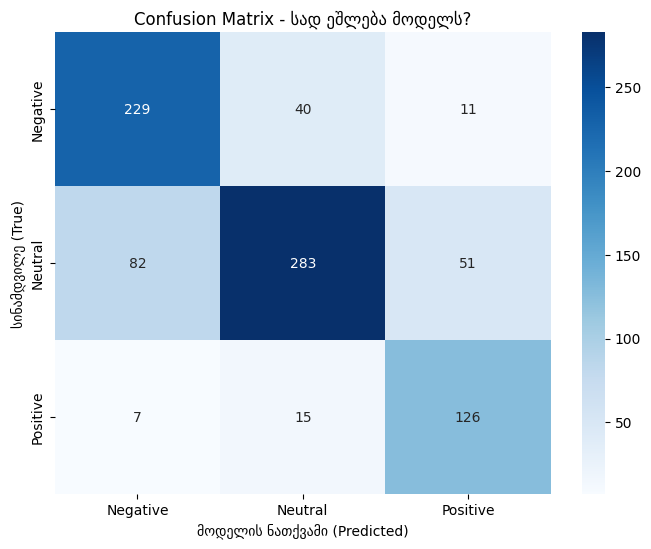

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

all_preds = []
all_labels = []

model.eval()
for i in range(len(tokenized_test)):
    input_ids = tokenized_test[i]["input_ids"].unsqueeze(0).to(device)
    attention_mask = tokenized_test[i]["attention_mask"].unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits

    all_preds.append(torch.argmax(logits, dim=1).item())
    all_labels.append(tokenized_test[i]["label"].item())

# მატრიცის აგება
cm = confusion_matrix(all_labels, all_preds)
labels = ["Negative", "Neutral", "Positive"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('მოდელის ნათქვამი (Predicted)')
plt.ylabel('სინამდვილე (True)')
plt.title('Confusion Matrix - სად ეშლება მოდელს?')
plt.show()

In [44]:
model_path = "./final_model"  #რეპოზიტორის სახელი
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

labels = ["Negative", "Neutral", "Positive"]

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    return {labels[i]: float(probabilities[0][i]) for i in range(3)}

demo = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(placeholder="ჩაწერე კომენტარი აქ...", lines=2),
    outputs=gr.Label(num_top_classes=3),
    title="ქართული სოციალური მედიის სენტიმენტ-ანალიზი",
    description="შეიყვანეთ ტექსტი, რათა გაიგოთ, არის ის პოზიტიური, ნეგატიური თუ ნეიტრალური."
)

demo.launch()

The tokenizer you are loading from './final_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://616ce2715aa6fd0823.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [45]:
import torch
from tqdm.auto import tqdm

# ვიგებ accuracy-ს
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

correct = 0
total = len(tokenized_test)

print("სიზუსტის დათვლა")

for i in tqdm(range(total)):

    inputs = {
        "input_ids": tokenized_test[i]["input_ids"].unsqueeze(0).to(device),
        "attention_mask": tokenized_test[i]["attention_mask"].unsqueeze(0).to(device)
    }
    true_label = tokenized_test[i]["label"].item()

    with torch.no_grad():
        outputs = model(**inputs)

    prediction = torch.argmax(outputs.logits, dim=-1).item()

    if prediction == true_label:
        correct += 1

#შედეგი გამომაქვს პროცენტებში
accuracy = correct / total
print("\n" + "="*30)
print(f"საბოლოო სიზუსტე (Accuracy): {accuracy:.2%}")
print("="*30)

სიზუსტის დათვლა


  0%|          | 0/844 [00:00<?, ?it/s]


საბოლოო სიზუსტე (Accuracy): 75.59%


In [47]:
import shutil

shutil.make_archive("my_georgian_model", 'zip', "final_model")

print("მოდელი დაზიპდა")

მოდელი დაზიპდა
